## Problem Formalization with pymoo

### Multi-Objective EV Control Problem
We model the **Electric Vehicle Control Problem** as a constrained bi-objective optimization:

\begin{aligned}
\text{Minimize:} \quad & \mathbf{J}(u) = \begin{bmatrix} T \\ E(u) \end{bmatrix} \\
\text{Subject to:} \quad & \text{Dynamics and constraints below}
\end{aligned}

---

### Objectives

1. **Minimize Arrival Time**  
    \begin{aligned}
   T = \inf \left\{ t \, \big| \, x(t) = D \right\}
   \end{aligned}
   - $D$: Total travel distance  
   - $x(t)$: Position at time $t$

2. **Minimize Energy Consumption**  
   \begin{aligned}
   E(u) = \int_0^T P\big(u(t), v(t)\big) \, dt
   \end{aligned}
   \begin{aligned}
   P(u,v) = \frac{u(t) \cdot v(t)}{\eta} + P_{\text{aux}}
   \end{aligned}
   - $\eta$: Motor efficiency (0 < $\eta$ ≤ 1)  
   - $P_{\text{aux}}$: Constant auxiliary power  
   - $u(t)$: Control input (acceleration/deceleration)  
   - $v(t)$: Velocity

---

### Vehicle Dynamics (Constraints)

\begin{aligned}
\begin{cases}
\dot{x}(t) = v(t) & \text{(Position dynamics)} \\
\dot{v}(t) = u(t) - \frac{1}{m}\big(F_{\text{drag}}(v(t)) + F_{\text{roll}}\big) & \text{(Velocity dynamics)} \\
F_{\text{drag}}(v) = \frac{1}{2} \rho C_d A v^2 & \text{(Drag force)} \\
F_{\text{roll}} = C_r m g & \text{(Rolling resistance)}
\end{cases}
\end{aligned}

**Boundary Conditions**:
\begin{aligned}
x(0) = 0, \quad v(0) = 0, \quad x(T) = D
\end{aligned}

**Control and State Constraints**:
\begin{aligned}
u_{\text{min}} \leq u(t) \leq u_{\text{max}}, \quad 0 \leq v(t) \leq v_{\text{max}}
\end{aligned}

---

### Pareto Optimality
The Pareto front $ \mathcal{X}_{\text{Pareto}} $ consists of non-dominated solutions:
\begin{aligned}
\mathcal{X}_{\text{Pareto}} = \left\{ \mathbf{J}_i = [T_i, E_i]^T \, \big| \, \nexists \, \mathbf{J}_j \text{ where } T_j \leq T_i \text{ and } E_j \leq E_i \right\}
\end{aligned}


In [18]:
import numpy as np
from typing import Tuple, List
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.core.population import Population

class EVControlProblem(Problem):
    """Electric Vehicle Control Optimization Problem
    Objectives: Minimize travel time and energy consumption
    Constraints: Speed limits, distance completion, energy budget"""

    def __init__(self) -> None:
        # Vehicle physical parameters (all in SI units)
        self.vehicle_mass_kg: float = 1000          # Mass of the vehicle
        self.air_density_kgm3: float = 1.225        # Air density at sea level
        self.drag_coefficient: float = 0.24         # Aerodynamic drag coefficient
        self.frontal_area_m2: float = 2.4           # Vehicle frontal area
        self.rolling_coefficient: float = 0.008     # Tire rolling resistance coefficient
        self.motor_efficiency: float = 0.85         # Drivetrain efficiency (0-1)
        self.auxiliary_power_w: float = 300         # Constant power for electronics/etc
        self.max_speed_mps: float = 30              # Speed limit (≈108 km/h)
        self.target_distance_m: float = 1000        # Total trip distance

        # Bounds for acceleration/deceleration control inputs [m/s²]
        min_acceleration: float = 0.3  # Minimum allowed acceleration/deceleration
        max_acceleration: float = 4.0  # Maximum allowed acceleration/deceleration

        # Initialize problem with 2 objectives, 2 variables, and 4 constraints
        super().__init__(
            n_var=2,
            n_obj=2,
            n_constr=4,
            xl=np.array([min_acceleration, min_acceleration]),
            xu=np.array([max_acceleration, max_acceleration])
        )

    def _calculate_aerodynamic_drag(self, velocity_mps: np.ndarray) -> np.ndarray:
        """Compute aerodynamic drag force at given velocity

        Args:
            velocity_mps: Array of velocity values [m/s]

        Returns:
            drag_force: Array of drag forces [N]
        """
        return 0.5 * self.air_density_kgm3 * self.drag_coefficient * \
               self.frontal_area_m2 * velocity_mps**2

    def _calculate_rolling_resistance(self) -> float:
        """Compute constant rolling resistance force

        Returns:
            rolling_force: Rolling resistance force [N]
        """
        return self.rolling_coefficient * self.vehicle_mass_kg * 9.81

    def _simulate_vehicle_motion(self,
                               acceleration_phase1: float,
                               acceleration_phase2: float
                               ) -> Tuple[float, np.ndarray, np.ndarray, float, float, float]:
        """Simulate vehicle motion through acceleration and deceleration phases

        Args:
            acceleration_phase1: Acceleration in first phase [m/s²]
            acceleration_phase2: Deceleration in second phase [m/s²]

        Returns:
            total_time_s: Total trip duration [s]
            velocity_profile_mps: Velocity at each time step [m/s]
            time_steps_s: Time points for simulation [s]
            acceleration_duration_s: Time spent accelerating [s]
            deceleration_duration_s: Time spent decelerating [s]
            peak_velocity_mps: Maximum velocity reached [m/s]
        """
        # Phase 1: Acceleration until either reaching max speed or halfway point
        acceleration_duration_s: float = min(
            self.max_speed_mps/acceleration_phase1,
            np.sqrt(2*self.target_distance_m/acceleration_phase1)
        )
        peak_velocity_mps: float = acceleration_phase1 * acceleration_duration_s

        # Phase 2: Deceleration to rest
        distance_covered_m: float = 0.5 * acceleration_phase1 * acceleration_duration_s**2
        remaining_distance_m: float = max(0, self.target_distance_m - distance_covered_m)
        deceleration_duration_s: float = np.sqrt(2*remaining_distance_m/acceleration_phase2) \
                                      if acceleration_phase2 > 0 else 0

        total_time_s: float = acceleration_duration_s + deceleration_duration_s

        # Generate velocity profile over time
        time_steps_s: np.ndarray = np.linspace(0, total_time_s, 100)
        velocity_profile_mps: np.ndarray = np.piecewise(
            time_steps_s,
            [time_steps_s <= acceleration_duration_s,
             time_steps_s > acceleration_duration_s],
            [lambda t: acceleration_phase1*t,
             lambda t: peak_velocity_mps - acceleration_phase2*(t-acceleration_duration_s)]
        )

        return (total_time_s, velocity_profile_mps, time_steps_s,
                acceleration_duration_s, deceleration_duration_s, peak_velocity_mps)

    def _calculate_energy_consumption(self,
                                    acceleration_profile: np.ndarray,
                                    velocity_profile: np.ndarray,
                                    time_steps: np.ndarray
                                    ) -> float:
        """Compute total energy consumption in kWh

        Args:
            acceleration_profile: Acceleration at each time step [m/s²]
            velocity_profile: Velocity at each time step [m/s]
            time_steps: Corresponding time points [s]

        Returns:
            energy_kwh: Total energy consumed [kWh]
        """
        drag_force: np.ndarray = self._calculate_aerodynamic_drag(velocity_profile)
        rolling_force: float = self._calculate_rolling_resistance()

        # Power = (F_total * v)/η + P_aux
        total_power_w: np.ndarray = (
            (acceleration_profile * velocity_profile *
            (self.vehicle_mass_kg + drag_force + rolling_force)) / self.motor_efficiency \
            + self.auxiliary_power_w)

        # Integrate power over time and convert to kWh
        return float(np.trapezoid(total_power_w, time_steps) / (1000 * 3600))

    def _evaluate(self,
                 control_inputs: np.ndarray,
                 out: dict,
                 *args,
                 **kwargs
                 ) -> None:
        """Evaluate solutions (main interface for optimization)

        Args:
            control_inputs: Array of acceleration pairs (phase1, phase2)
            out: Dictionary to store objectives and constraints
        """
        travel_times: List[float] = []
        energy_consumptions: List[float] = []
        constraint_violations: List[List[float]] = []

        for accel_phase1, accel_phase2 in control_inputs:
            # Simulate vehicle motion with current control inputs
            (trip_duration_s, velocity_mps, time_points_s,
             accel_time_s, decel_time_s, max_velocity_mps) = \
                self._simulate_vehicle_motion(accel_phase1, accel_phase2)

            # Create acceleration profile (positive then negative)
            peak_velocity_idx: int = np.argmax(velocity_mps)
            acceleration_profile: np.ndarray = np.where(
                time_points_s <= time_points_s[peak_velocity_idx],
                accel_phase1,
                -accel_phase2
            )

            # Calculate energy consumption
            energy_kwh: float = self._calculate_energy_consumption(
                acceleration_profile, velocity_mps, time_points_s)

            # Calculate final position for distance constraint
            final_position_m: float = (
                0.5 * accel_phase1 * accel_time_s**2 +
                (max_velocity_mps * decel_time_s -
                 0.5 * accel_phase2 * decel_time_s**2)
            )

            # Normalized constraints (must be <= 0)
            speed_limit_violation: float = (max(velocity_mps) - self.max_speed_mps) / self.max_speed_mps
            distance_overshoot: float = (final_position_m - self.target_distance_m) / self.target_distance_m
            distance_undershoot: float = (self.target_distance_m - final_position_m) / self.target_distance_m
            energy_limit_violation: float = (energy_kwh - 1.5) / 1.5  # 1.5 kWh budget

            travel_times.append(trip_duration_s)
            energy_consumptions.append(energy_kwh)
            constraint_violations.append([
                speed_limit_violation,
                distance_overshoot,
                distance_undershoot,
                energy_limit_violation
            ])

        out["F"] = np.column_stack([travel_times, energy_consumptions])
        out["G"] = np.array(constraint_violations)


## NSGA-II Optimization Progress Metrics

### Table Column Definitions
| Column        | Description                                                                 | Interpretation                                                                 |
|---------------|-----------------------------------------------------------------------------|--------------------------------------------------------------------------------|
| **`n_gen`**   | Current generation number                                                   | Tracks optimization progress (1 → N)                                           |
| **`n_eval`**  | Cumulative function evaluations                                             | Total objective function calls (time + energy calculations)                    |
| **`n_nds`**   | Non-dominated solutions in population                                       | Count of Pareto-optimal solutions found                                        |
| **`cv_min`**  | Minimum constraint violation                                                | `0.0` = feasible solution exists                                               |
| **`cv_avg`**  | Average constraint violation across population                              | Lower values → better feasibility                                              |
| **`eps`**     | Generational improvement (ε-progress)                                       | Measures movement of Pareto front                                              |
| **`indicator`**| Reference point for ε calculation                                          | Shows what drove improvement                                                   |

### Key Metric Details
#### Constraint Violations (`cv_min`, `cv_avg`)
- **`0.000000E+00`**: Perfect feasibility (all constraints satisfied)
- **Decreasing values**: Population is becoming more feasible
- **Example**: `cv_avg=0.565` → Average solution violates constraints by ~56.5%

#### Pareto Front Progress (`eps`)
| Value Range    | Interpretation                          | Example           |
|----------------|----------------------------------------|-------------------|
| **`0.01-0.1`** | Good improvement                       | `0.056` (Gen 4)  |
| **`<0.01`**    | Convergence                            | `0.001`          |
| **`-`**        | No comparison (first generation)       | Gen 1            |

#### Improvement Indicators
| Indicator  | Meaning                                                                 | When It Appears               |
|------------|-------------------------------------------------------------------------|-------------------------------|
| `ideal`    | Progress toward best possible values                                   | Early optimization (Gens 2-4) |
| `nadir`    | Progress away from worst-case values                                   | Late-stage refinement         |
| `f`        | General front movement (mixed criteria)                                | Middle phases                 |

### Your Optimization Status
1. **Feasibility Achieved**: `cv_min=0.0` since Gen 1 → Valid solutions exist  
2. **Rapid Improvement**: Large `eps` drops (0.166 → 0.056) → Effective exploration  
3. **Pareto Growth**: `n_nds` increasing (4 → 63) → Discovering more optimal solutions  
4. **Ideal-Driven**: Early `indicator=ideal` → Focusing on best potential outcomes

In [24]:
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.core.result import Result

# Create and solve problem
ev_problem: EVControlProblem = EVControlProblem()

# Optimization setup with tuned operators
optimization_algorithm: NSGA2 = NSGA2(
        pop_size=200,
        sampling=FloatRandomSampling(),
        crossover=SBX(prob=0.9, eta=15),
        mutation=PolynomialMutation(prob=0.2, eta=20),
        eliminate_duplicates=True
    )

result = minimize(
    problem=ev_problem,
    algorithm=optimization_algorithm,
    termination=('n_gen', 23),
    seed=42,
    save_history=True,
    verbose=True
)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      200 |      4 |  0.000000E+00 |  0.5652151001 |             - |             -
     2 |      400 |     10 |  0.000000E+00 |  0.1729439740 |  0.1664111011 |         ideal
     3 |      600 |     26 |  0.000000E+00 |  0.0325690482 |  0.1205127714 |         ideal
     4 |      800 |     63 |  0.000000E+00 |  1.437266E-09 |  0.0563143111 |         ideal
     5 |     1000 |    135 |  0.000000E+00 |  3.694822E-17 |  0.0023294277 |             f
     6 |     1200 |    200 |  0.000000E+00 |  0.000000E+00 |  0.0043427078 |             f
     7 |     1400 |    200 |  0.000000E+00 |  0.000000E+00 |  0.0189334337 |         ideal
     8 |     1600 |    200 |  0.000000E+00 |  0.000000E+00 |  0.0005771366 |             f
     9 |     1800 |    200 |  0.000000E+00 |  0.000000E+00 |  0.0012762540 |             f
    10 |     2000 |    200 |  0.000000E+00 |  0.000000E+00 |  0.0042867339 |         ideal

In [25]:
# Show first 5 pareto-solutions
print(f"All solutions shape: {result.F.shape}")  # e.g., (2000, 2)
print("First 5 solutions (Time, Energy):")
print(result.F[:5])

All solutions shape: (200, 2)
First 5 solutions (Time, Energy):
[[81.64835133  0.12291894]
 [66.67006517  0.18748435]
 [81.64835133  0.12291894]
 [78.01459753  0.13476842]
 [69.89921749  0.16941561]]


## 3. Extract and Visualize Pareto Solutions
Get Non-Dominated Solutions


In [26]:
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting

# Extract all solutions
F = result.F  # Objective values (T, E)

# Filter non-dominated solutions
nds_indices = NonDominatedSorting().do(F)
pareto_front = F[nds_indices]

print(f"Found {len(pareto_front)} Pareto-optimal solutions.")


Found 1 Pareto-optimal solutions.


### Visualize the Pareto Front


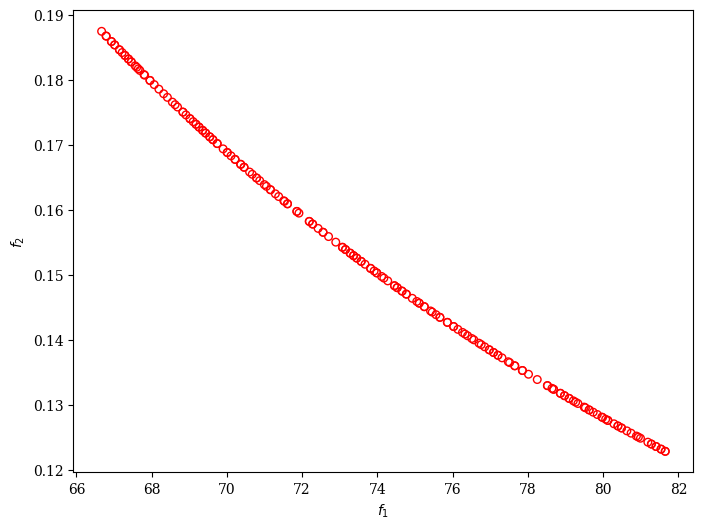

In [27]:
from pymoo.visualization.scatter import Scatter
from pymoo.problems import get_problem
import matplotlib.pyplot as plt

plot = Scatter()
plot.add(F, s=30, facecolors='none', edgecolors='r')
plot.show()


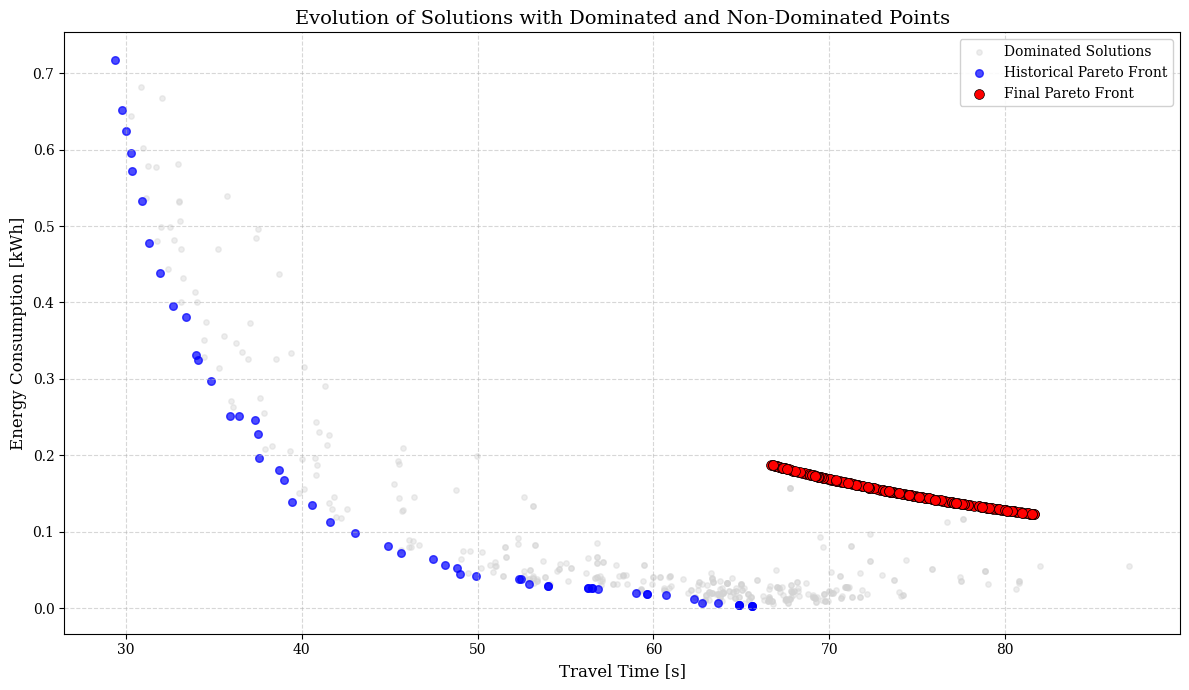

In [28]:
all_F = []
for algo in result.history:
    all_F.extend([ind.F for ind in algo.pop])
all_F = np.array(all_F)

# Identify non-dominated solutions from entire history
nds = NonDominatedSorting()
fronts = nds.do(all_F, only_non_dominated_front=False)
pareto_mask = np.zeros(len(all_F), dtype=bool)
pareto_mask[fronts[0]] = True  # First front is Pareto optimal

plt.figure(figsize=(12, 7))

# Plot dominated solutions (gray)
plt.scatter(all_F[~pareto_mask, 0], all_F[~pareto_mask, 1],
            c='lightgray', s=15, alpha=0.4, label="Dominated Solutions")

# Plot historical non-dominated solutions (blue)
plt.scatter(all_F[pareto_mask, 0], all_F[pareto_mask, 1],
            c='blue', s=30, alpha=0.7, label="Historical Pareto Front")

# Plot final optimized Pareto front (red)
if result.F.size > 0:
    plt.scatter(result.F[:, 0], result.F[:, 1],
                c='red', s=50, edgecolor='black', lw=0.5,
                label="Final Pareto Front", zorder=10)

plt.xlabel("Travel Time [s]", fontsize=12)
plt.ylabel("Energy Consumption [kWh]", fontsize=12)
plt.title("Evolution of Solutions with Dominated and Non-Dominated Points", fontsize=14)
plt.legend(loc='upper right', framealpha=0.9)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [30]:
all_F.shape

(4600, 2)